# Detection of microscope inside or outside sample



In this notebook, we train a CNN on augmented images from two different regions: inside and outside microscope. We call them terrains.  A good terrain is INSIDE the sample area, a bad terrain is OUTSIDE the sample area. The problem is equivalent to classify textures and could be achieved by feature extraction. However, we have found that a simple Convolutional Neural Network can achieve similar or better results in many cases.

- "crosses" : class 0
- "terrain" : class 0
- "out" : class 1

A classifier is trained to differentiate then between the 2 types of objects. 


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                     # OpenCV library for computer vision
from PIL import Image
import time 
from shutil import copyfile
from tqdm import tqdm
import glob
import os

In [2]:
from keras import backend as K
from imp import reload
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

C:\Users\lleti\AppData\Local\conda\conda\envs\deepl\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# MODIFY THIS: folder with TERRAIN
# Prepare a list with all files corresponding to terrain (not crosses)
dirSample = ".\\data"
terrain = glob.glob(dirSample+"\\valid\\*.tif")

In [4]:
# MODIFY THIS: folder with OUT
# Prepare a list with all files corresponding to OUT
dirSample = ".\\data"
out = glob.glob(dirSample+"\\not_valid\\*.tif")

In [5]:
# PART 1: READ images
# PREPROCESSING: blur, clahe, normalization between 0-1
# Functions to prepare images

from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from skimage.morphology import disk
from skimage.filters.rank import mean_bilateral
from skimage.filters.rank import enhance_contrast_percentile


# All images are preprocessed for unbalanced brightness and contrast and resized to 128 by 128
def preprocess(image):
    # Local contrast enhancement
    enh = enhance_contrast_percentile(image, disk(3), p0=.1, p1=.9)
    # img = mean_bilateral(img, disk(20), s0=10, s1=10)
    # img =  cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # image = cv2.GaussianBlur(enh,(3,3),0)
    image = cv2.resize(enh, (256, 256)) 
    #iclahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    #n_image = iclahe.apply(np.uint8(image))
    
    final = np.array(image,dtype=np.float32)
    #final = final/255. Don't do this before augmentation
    return final


def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    img = preprocess(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 1) and return 4D tensor    
    return np.expand_dims(img, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [6]:
# We need balanced classes
total_good  = len(terrain)
total_bad = len(out)
print('We have a total of terrain : '+str(total_good)+" and a total of outs :"+str(total_bad))

We have a total of terrain : 452 and a total of outs :422


In [7]:
# Read bad tensors
tout = paths_to_tensor(out)

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [01:06<00:00,  6.37it/s]


In [8]:
# Augment goods and bads until 3000
import imgaug as ia
import random
from imgaug import augmenters as iaa

ia.seed(5)

# Amplify train_tensors
list_of_tensors_out = []
inc = int(2000/total_bad)
for i in range (inc):
    for ind,tensor in enumerate(tout):
        img_or = tout[ind,:,:]
        seq = iaa.SomeOf(2,[
            iaa.Fliplr(1.0), # horizontal flips
            iaa.Flipud(1.0),# vertical flips
            iaa.Invert(1.0), # change brightness
            iaa.Add((-20,20)),
            iaa.Multiply((0.9,1.5)),
            iaa.Affine(rotate=(-5,5),scale=(0.9, 1.1))])

        seq_det = seq.to_deterministic()

        # Augment keypoints and images.
        image_aug = seq_det.augment_images([img_or])[0]
        ntensor = np.expand_dims(image_aug, axis=0)
        ntensor = np.uint8(ntensor)
        list_of_tensors_out.append(ntensor)


In [9]:
list_of_tensors_out_total =  np.vstack([tout,np.squeeze(list_of_tensors_out)])
indexes = list(range(list_of_tensors_out_total.shape[0]))
list_of_tensors_bad =  np.array([ (cv2.cvtColor(list_of_tensors_out_total[i],cv2.COLOR_GRAY2RGB)-127.)/128. for i in indexes])
total = list_of_tensors_bad.shape

In [10]:
list_of_bad = np.zeros((total[0],1))+1

In [11]:
terrain = paths_to_tensor(terrain)

100%|████████████████████████████████████████████████████████████████████████████████| 452/452 [00:51<00:00,  8.80it/s]


In [12]:
import imgaug as ia
import random
from imgaug import augmenters as iaa

ia.seed(7)

inc = int(2000/total_good)
list_of_tensors_terrain = []
for i in range(inc):
    for ind,tensor in enumerate(terrain):
        img_or = terrain[ind,:,:]
        seq = iaa.SomeOf(2,[
            iaa.Fliplr(1.0), # horizontal flips
            iaa.Flipud(1.0),# vertical flips
            iaa.Invert(1.0), # change brightness
            iaa.Add((-20,20)),
            iaa.Multiply((0.9,1.2)),
            iaa.Affine(rotate=(-5,5),scale=(0.9, 1.1))])

        seq_det = seq.to_deterministic()

        # Augment keypoints and images.
        image_aug = seq_det.augment_images([img_or])[0]

        ntensor = np.expand_dims(image_aug, axis=0)
        ntensor = np.uint8(ntensor)
        list_of_tensors_terrain.append(ntensor)

In [13]:
list_of_tensors_good =  np.vstack([terrain,np.squeeze(list_of_tensors_terrain)])
indexes = list(range(list_of_tensors_good.shape[0]))
list_of_tensors_good = np.array([ (cv2.cvtColor(list_of_tensors_good[i],cv2.COLOR_GRAY2RGB)-127.)/128. for i in indexes])
total = list_of_tensors_good.shape

In [14]:
list_of_good = np.zeros((total[0],1))

In [15]:
# Generate classes
from keras.utils import np_utils
f_train =np.vstack([list_of_tensors_bad,list_of_tensors_good])

In [16]:
y_train = np.vstack([list_of_bad, list_of_good])

In [17]:
class_targets = np_utils.to_categorical(y_train, 2)

In [18]:
print(list_of_bad.shape[0])
print(list_of_good.shape[0])

2110
2260


Put all data together and shuffle :

In [19]:
indexes = list(range(f_train.shape[0]))
random.shuffle(indexes)
f_train_tensors = np.array([ f_train[i] for i in indexes])
f_class_targets = np.array([ class_targets[i] for i in indexes])


In [20]:
f_train_tensors.shape

(4370, 256, 256, 3)

In [21]:
total_bad = np.sum(np.argmax(f_class_targets,axis=1)==1)
total_bad

2110

In [22]:
# Split in train, test. Dev will be used as % of train
x_train, x_test, y_train, y_test = train_test_split(f_train_tensors, f_class_targets , test_size=0.1, random_state=1)

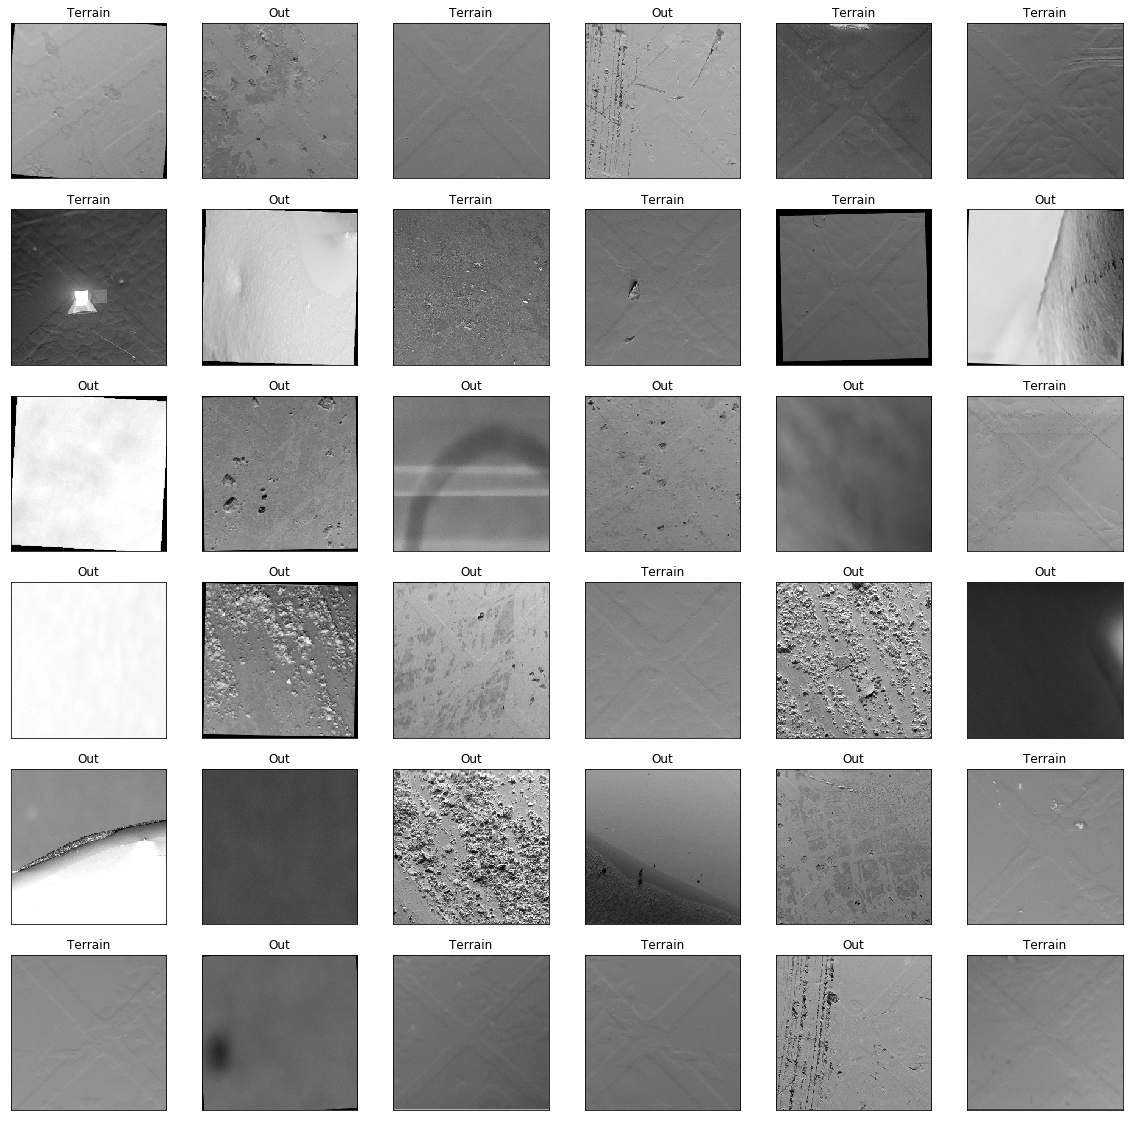

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,20))
for i in range(36):
    ix = i+1000
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    img = f_train_tensors[ix,:,:]
    ax.imshow(np.uint8(np.squeeze((img)*128)+127))
    if(np.argmax(f_class_targets[ix])==0):
        ax.set_title("Terrain")
    else:
        ax.set_title("Out")
        

In [24]:
### TODO: Define your architecture
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense
from keras.models import Model
VGG16_model_no_top =  VGG16(weights='imagenet', include_top=False, pooling ='avg',input_shape=(256, 256, 3))


In [25]:

for layer in VGG16_model_no_top.layers:
    layer.trainable = False

x = VGG16_model_no_top.output
#x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)
VGG16_model = Model(inputs=VGG16_model_no_top.input,outputs = x)

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [26]:
x_train = np.squeeze(x_train)

In [27]:
x_train = np.expand_dims(x_train, axis=3)
#valid_tensors = np.expand_dims(valid_tensors, axis=3)

In [28]:
## TODO: Save the model as model.h5
nmodel_json = VGG16_model.to_json()
with open("model_TERRAIN_VGG16.json", "w") as json_file:
    json_file.write(nmodel_json)
print("Saved model to disk")

Saved model to disk


In [29]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
optim =  Adam(lr = 1e-3)# RMSprop(lr=0.0001)
VGG16_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
# VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
y_train.shape

(3933, 2)

In [31]:
x_train = np.squeeze(x_train)
x_train.shape


(3933, 256, 256, 3)

In [32]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.best_terrain_VGG16.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist = VGG16_model.fit(
        x_train, np.array(y_train),      
        validation_split=0.2,
        #validation_data = (valid_tensors,y_valid),
        batch_size = 32,
        epochs=350,
        verbose =2,
        callbacks = [checkpointer])


Train on 3146 samples, validate on 787 samples
Epoch 1/350
 - 38s - loss: 0.6099 - acc: 0.6825 - val_loss: 0.5502 - val_acc: 0.7395

Epoch 00001: val_loss improved from inf to 0.55017, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 2/350
 - 33s - loss: 0.5059 - acc: 0.7610 - val_loss: 0.4743 - val_acc: 0.7713

Epoch 00002: val_loss improved from 0.55017 to 0.47430, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 3/350
 - 33s - loss: 0.4469 - acc: 0.8156 - val_loss: 0.4239 - val_acc: 0.8628

Epoch 00003: val_loss improved from 0.47430 to 0.42393, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 4/350
 - 33s - loss: 0.4077 - acc: 0.8582 - val_loss: 0.3902 - val_acc: 0.8895

Epoch 00004: val_loss improved from 0.42393 to 0.39019, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 5/350
 - 33s - loss: 0.3787 - acc: 0.8783 - val_loss: 0.3645 - val_acc: 0.8971

Epoch 00005: val_loss improved from 0.39019 to 0.36450, sav

Epoch 00041: val_loss improved from 0.18139 to 0.18021, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 42/350
 - 33s - loss: 0.1702 - acc: 0.9463 - val_loss: 0.1839 - val_acc: 0.9492

Epoch 00042: val_loss did not improve from 0.18021
Epoch 43/350
 - 33s - loss: 0.1672 - acc: 0.9466 - val_loss: 0.1806 - val_acc: 0.9492

Epoch 00043: val_loss did not improve from 0.18021
Epoch 44/350
 - 33s - loss: 0.1655 - acc: 0.9450 - val_loss: 0.1765 - val_acc: 0.9530

Epoch 00044: val_loss improved from 0.18021 to 0.17645, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 45/350
 - 33s - loss: 0.1634 - acc: 0.9491 - val_loss: 0.1772 - val_acc: 0.9517

Epoch 00045: val_loss did not improve from 0.17645
Epoch 46/350
 - 33s - loss: 0.1620 - acc: 0.9472 - val_loss: 0.1778 - val_acc: 0.9543

Epoch 00046: val_loss did not improve from 0.17645
Epoch 47/350
 - 33s - loss: 0.1614 - acc: 0.9498 - val_loss: 0.1756 - val_acc: 0.9543

Epoch 00047: val_loss improved from 0.17


Epoch 00087: val_loss improved from 0.14800 to 0.14694, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 88/350
 - 33s - loss: 0.1263 - acc: 0.9631 - val_loss: 0.1477 - val_acc: 0.9619

Epoch 00088: val_loss did not improve from 0.14694
Epoch 89/350
 - 33s - loss: 0.1253 - acc: 0.9638 - val_loss: 0.1460 - val_acc: 0.9632

Epoch 00089: val_loss improved from 0.14694 to 0.14600, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 90/350
 - 33s - loss: 0.1244 - acc: 0.9644 - val_loss: 0.1459 - val_acc: 0.9632

Epoch 00090: val_loss improved from 0.14600 to 0.14589, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 91/350
 - 33s - loss: 0.1249 - acc: 0.9631 - val_loss: 0.1478 - val_acc: 0.9619

Epoch 00091: val_loss did not improve from 0.14589
Epoch 92/350
 - 33s - loss: 0.1241 - acc: 0.9654 - val_loss: 0.1450 - val_acc: 0.9632

Epoch 00092: val_loss improved from 0.14589 to 0.14495, saving model to weights.best_terrain_VGG16.from_scratch


Epoch 00133: val_loss improved from 0.13329 to 0.13309, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 134/350
 - 33s - loss: 0.1091 - acc: 0.9685 - val_loss: 0.1328 - val_acc: 0.9657

Epoch 00134: val_loss improved from 0.13309 to 0.13278, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 135/350
 - 33s - loss: 0.1075 - acc: 0.9673 - val_loss: 0.1354 - val_acc: 0.9670

Epoch 00135: val_loss did not improve from 0.13278
Epoch 136/350
 - 33s - loss: 0.1080 - acc: 0.9692 - val_loss: 0.1322 - val_acc: 0.9657

Epoch 00136: val_loss improved from 0.13278 to 0.13216, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 137/350
 - 33s - loss: 0.1067 - acc: 0.9685 - val_loss: 0.1320 - val_acc: 0.9657

Epoch 00137: val_loss improved from 0.13216 to 0.13200, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 138/350
 - 33s - loss: 0.1065 - acc: 0.9695 - val_loss: 0.1320 - val_acc: 0.9657

Epoch 00138: val_loss improved from 0.13

Epoch 00180: val_loss improved from 0.12505 to 0.12453, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 181/350
 - 34s - loss: 0.0965 - acc: 0.9727 - val_loss: 0.1259 - val_acc: 0.9657

Epoch 00181: val_loss did not improve from 0.12453
Epoch 182/350
 - 33s - loss: 0.0966 - acc: 0.9727 - val_loss: 0.1245 - val_acc: 0.9682

Epoch 00182: val_loss improved from 0.12453 to 0.12446, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 183/350
 - 33s - loss: 0.0957 - acc: 0.9727 - val_loss: 0.1245 - val_acc: 0.9682

Epoch 00183: val_loss did not improve from 0.12446
Epoch 184/350
 - 33s - loss: 0.0956 - acc: 0.9711 - val_loss: 0.1245 - val_acc: 0.9644

Epoch 00184: val_loss did not improve from 0.12446
Epoch 185/350
 - 34s - loss: 0.0957 - acc: 0.9730 - val_loss: 0.1239 - val_acc: 0.9670

Epoch 00185: val_loss improved from 0.12446 to 0.12389, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 186/350
 - 33s - loss: 0.0959 - acc: 0.9711 - val_


Epoch 00230: val_loss improved from 0.11884 to 0.11868, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 231/350
 - 33s - loss: 0.0871 - acc: 0.9765 - val_loss: 0.1196 - val_acc: 0.9670

Epoch 00231: val_loss did not improve from 0.11868
Epoch 232/350
 - 33s - loss: 0.0872 - acc: 0.9755 - val_loss: 0.1186 - val_acc: 0.9682

Epoch 00232: val_loss improved from 0.11868 to 0.11862, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 233/350
 - 34s - loss: 0.0873 - acc: 0.9765 - val_loss: 0.1183 - val_acc: 0.9670

Epoch 00233: val_loss improved from 0.11862 to 0.11830, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 234/350
 - 33s - loss: 0.0872 - acc: 0.9749 - val_loss: 0.1182 - val_acc: 0.9682

Epoch 00234: val_loss improved from 0.11830 to 0.11823, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 235/350
 - 33s - loss: 0.0876 - acc: 0.9739 - val_loss: 0.1186 - val_acc: 0.9695

Epoch 00235: val_loss did not improve fr

Epoch 281/350
 - 33s - loss: 0.0817 - acc: 0.9765 - val_loss: 0.1145 - val_acc: 0.9682

Epoch 00281: val_loss improved from 0.11467 to 0.11452, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 282/350
 - 33s - loss: 0.0811 - acc: 0.9771 - val_loss: 0.1143 - val_acc: 0.9708

Epoch 00282: val_loss improved from 0.11452 to 0.11427, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 283/350
 - 33s - loss: 0.0809 - acc: 0.9768 - val_loss: 0.1146 - val_acc: 0.9708

Epoch 00283: val_loss did not improve from 0.11427
Epoch 284/350
 - 33s - loss: 0.0809 - acc: 0.9777 - val_loss: 0.1146 - val_acc: 0.9682

Epoch 00284: val_loss did not improve from 0.11427
Epoch 285/350
 - 33s - loss: 0.0809 - acc: 0.9768 - val_loss: 0.1145 - val_acc: 0.9682

Epoch 00285: val_loss did not improve from 0.11427
Epoch 286/350
 - 33s - loss: 0.0806 - acc: 0.9768 - val_loss: 0.1151 - val_acc: 0.9682

Epoch 00286: val_loss did not improve from 0.11427
Epoch 287/350
 - 33s - loss: 0.080

Epoch 00331: val_loss improved from 0.11134 to 0.11110, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 332/350
 - 33s - loss: 0.0761 - acc: 0.9787 - val_loss: 0.1124 - val_acc: 0.9708

Epoch 00332: val_loss did not improve from 0.11110
Epoch 333/350
 - 33s - loss: 0.0760 - acc: 0.9793 - val_loss: 0.1124 - val_acc: 0.9708

Epoch 00333: val_loss did not improve from 0.11110
Epoch 334/350
 - 33s - loss: 0.0758 - acc: 0.9784 - val_loss: 0.1133 - val_acc: 0.9670

Epoch 00334: val_loss did not improve from 0.11110
Epoch 335/350
 - 33s - loss: 0.0763 - acc: 0.9793 - val_loss: 0.1107 - val_acc: 0.9720

Epoch 00335: val_loss improved from 0.11110 to 0.11069, saving model to weights.best_terrain_VGG16.from_scratch.hdf5
Epoch 336/350
 - 33s - loss: 0.0757 - acc: 0.9787 - val_loss: 0.1110 - val_acc: 0.9708

Epoch 00336: val_loss did not improve from 0.11069
Epoch 337/350
 - 33s - loss: 0.0757 - acc: 0.9787 - val_loss: 0.1108 - val_acc: 0.9708

Epoch 00337: val_loss did not impr

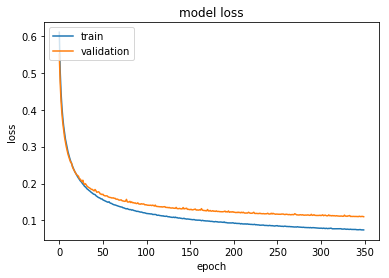

In [33]:
## TODO: Visualize the training and validation loss of your neural network
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model error')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.clf()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('./loss_curve.png')


plot_learning_curve(hist)
#img = cv2.imread('./accuracy_curve.png')


In [34]:
from keras.models import model_from_json
json_file = open('model_TERRAIN_VGG16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
nmodel = model_from_json(loaded_model_json)
nmodel.load_weights('weights.best_terrain_VGG16.from_scratch.hdf5')


In [35]:
#test_tensors = np.expand_dims(x_test, axis=3)
p_test = nmodel.predict(x_test)

In [36]:
x_test.shape

(437, 256, 256, 3)

In [37]:
pred = np.argmax(y_test, axis=1)
print(pred[0:50])

[0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1
 1 0 0 1 0 1 1 0 0 1 1 0 1]


In [38]:
predictions = np.argmax(p_test,axis=1)
# report test accuracy
test_accuracy = 100*np.sum(predictions==np.argmax(y_test, axis=1))/len(y_test)
print('Test accuracy : %.4f%%' % test_accuracy)

Test accuracy : 95.8810%


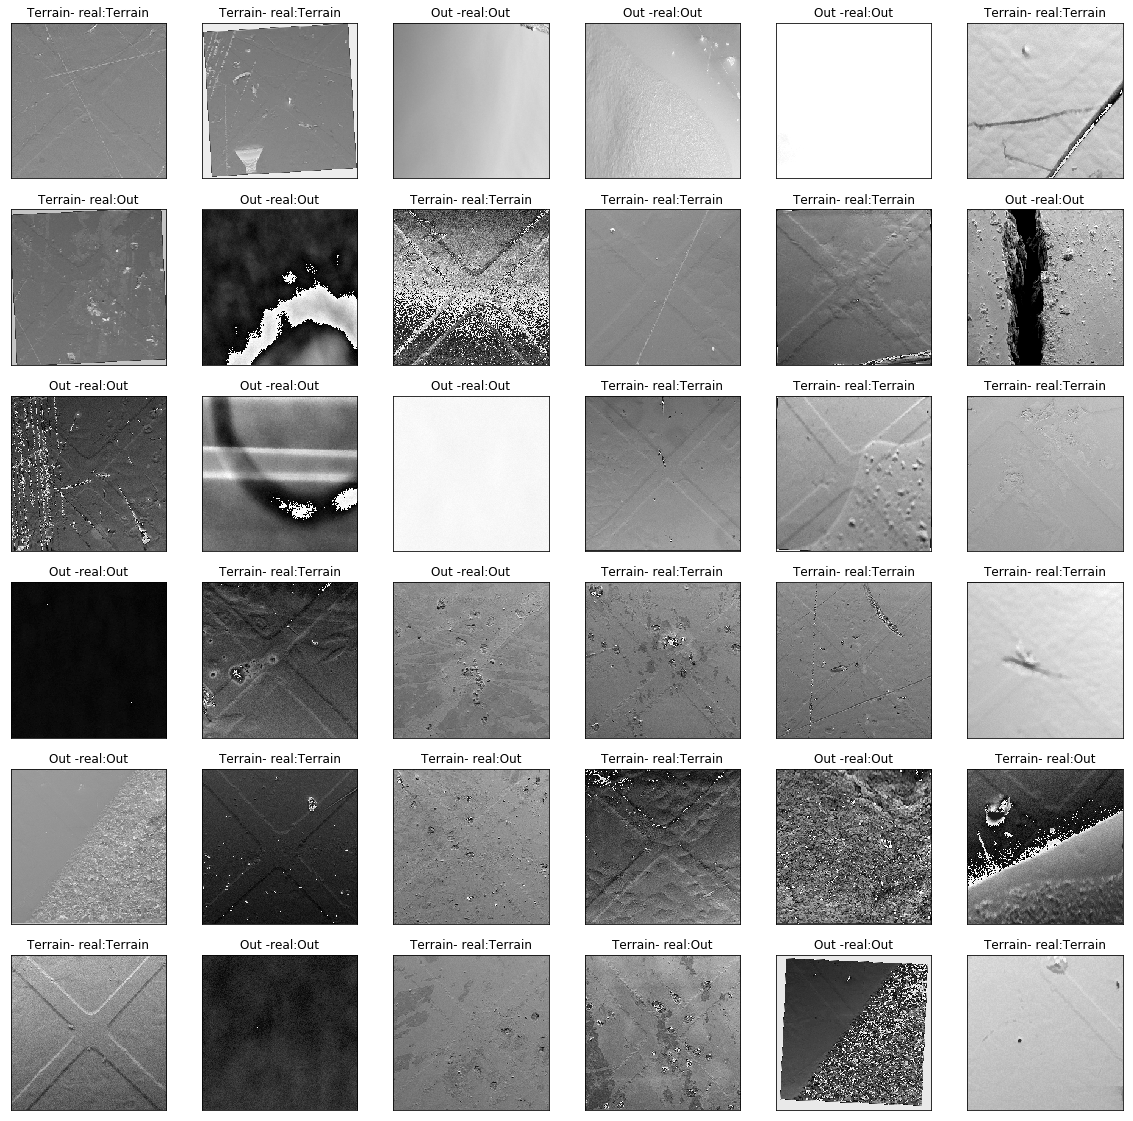

In [39]:
# load the weights that yielded the best validation accuracy
fig2 = plt.figure(figsize=(20,20))
for ix in range(36):
    ax2 = fig2.add_subplot(6, 6, ix+1, xticks=[], yticks=[])
    img = x_test[ix,:,:]
    ax2.imshow(np.squeeze(np.uint8((img/np.max(img))*128 +127)))
    if pred[ix]==0 :
        sol = "Terrain"
    else:
        sol = "Out"
    if(predictions[ix]==0):
        ax2.set_title("Terrain- real:"+sol)
    else:
        ax2.set_title("Out -real:"+sol)

In [40]:
# Load TEST
dirSample = ".\\data\\TEST\\TEST2\\*"
flist = glob.glob(dirSample)

In [41]:
sample_test = [] 

flistdir= [f for f in flist if os.path.isdir(f)]
if flistdir is None:
        raise Exception('--scanfolder not found')

for sample in flistdir:
    flist2 = glob.glob(sample + "\\ref*.tif")
    sample_test.append(flist2[0])


In [42]:
sample_test

['.\\data\\TEST\\TEST2\\f1\\ref_3_7W_201805051726056369.tif',
 '.\\data\\TEST\\TEST2\\a1\\ref_0_iM_201810221324377000.tif']

In [43]:
test_tensors2 = paths_to_tensor(sample_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]


In [44]:
test_tensors2.shape

(2, 256, 256)

In [45]:
test_tensors2 = np.array([ (cv2.cvtColor(el, cv2.COLOR_GRAY2RGB)-127.) /128. for el in test_tensors2])

In [46]:
test_tensors2.shape

(2, 256, 256, 3)

In [47]:
p_test2= nmodel.predict(test_tensors2)

In [48]:
predictions = np.argmax(p_test2,axis=1)

In [49]:
predictions

array([0, 0], dtype=int64)

IndexError: index 2 is out of bounds for axis 0 with size 2

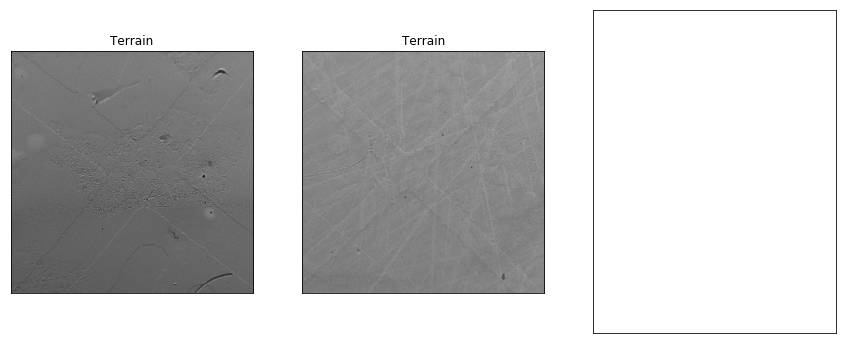

In [50]:
# load the weights that yielded the best validation accuracy
fig2 = plt.figure(figsize=(20,120))
for ix in range(49):
    ax2 = fig2.add_subplot(17,4, ix+1, xticks=[], yticks=[])
    img = test_tensors2[ix,:,:,:]
    ax2.imshow(np.squeeze(np.uint8((img)*128 +127)))
    if(predictions[ix]==0):
        ax2.set_title("Terrain")
    else:
        ax2.set_title("Out")